# Exploratory Data Analysis

O objetivo da nossa ferramenta é criar um preditor da posição subcelular de uma proteína com base em sua composição de aminoácidos

## Data Collection

In [10]:
#!curl --output-file ../data/raw/membrane.fasta 'https://www.uniprot.org/uniprot/?query=taxonomy%3Abacteria+locations%3A%28location%3Amembrane%29&sort=score&format=fasta&limit=10000'
#!curl --output ../data/raw/cytoplasm.fasta 'https://www.uniprot.org/uniprot/?query=locations%3A%28location%3Acytoplasm%29+taxonomy%3Abacteria&sort=score&format=fasta&limit=10000'

## Data Preprocessing

In [1]:
from Bio import SeqIO
from Bio.SeqUtils import ProtParam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
membrane_handle = open("../data/raw/membrane.fasta")
membrane_parser = SeqIO.parse(membrane_handle,'fasta')

cytoplasm_handle = open("../data/raw/cytoplasm.fasta")
cytoplasm_parser = SeqIO.parse(cytoplasm_handle,'fasta')

In [22]:
def analisa_proteina(sequencia):
  protein_analyzer = ProtParam.ProteinAnalysis(str(sequencia))
  protein_data = protein_analyzer.get_amino_acids_percent()
  return protein_data

In [23]:
df = pd.DataFrame()

for proteina in membrane_parser:
    protein_data = analisa_proteina(proteina)
    protein_data['membrane'] = 1
    df = df.append(protein_data, ignore_index=True)

for proteina2 in cytoplasm_parser:
    protein_data = analisa_proteina(proteina2)
    protein_data['membrane'] = 0
    df = df.append(protein_data, ignore_index=True)

## Exploratory Data Analysis

In [28]:
df_grouped = df.groupby('membrane').mean()
df_grouped

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
membrane,,,,,,,,,,,,,,,,,,,,
0.0,0.051454,0.012409,0.018842,0.019469,0.007718,0.024807,0.012618,0.020335,0.018512,0.027324,0.016356,0.021101,0.019246,0.010254,0.018111,0.028882,0.017180,0.024257,0.003244,0.006512
1.0,0.057955,0.010553,0.019811,0.018601,0.010284,0.022099,0.010897,0.022675,0.009837,0.023896,0.013360,0.021476,0.019435,0.009649,0.021646,0.028102,0.017693,0.019631,0.008177,0.006892


Populating the interactive namespace from numpy and matplotlib


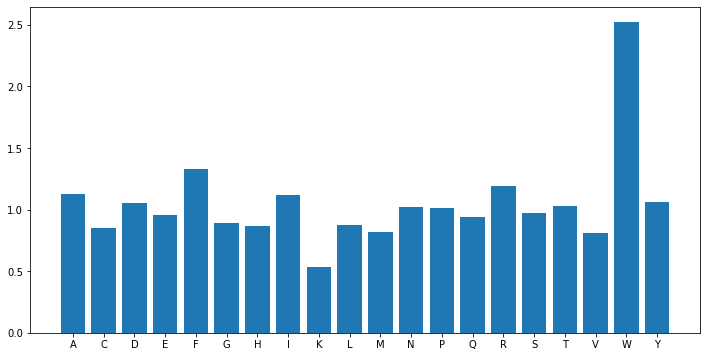

In [30]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12,6)

aminoacidos = df_grouped.columns

cytoplasm_mean_composition = df_grouped.loc[0]
membrane_mean_composition = df_grouped.loc[1]

relative_difference = membrane_mean_composition / cytoplasm_mean_composition

plt.bar(aminoacidos, relative_difference)
plt.show()

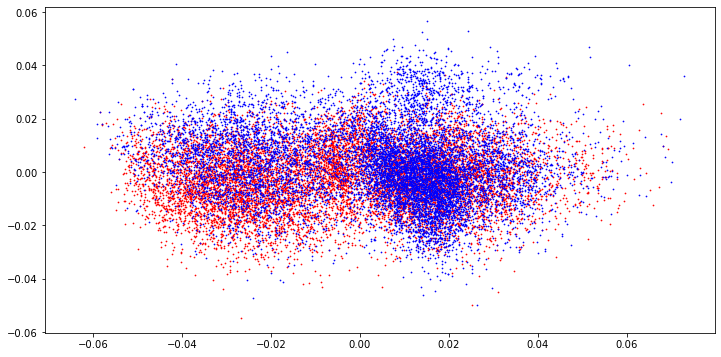

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df.drop(['membrane'], axis=1))

for group, df_group in df.groupby('membrane'):
    components = pca.transform(df_group.drop('membrane', axis=1))
    plt.scatter(components[:,0], components[:,1], s=0.5, label="membrane" if group == 0 else "cytoplasm", color='red' if group == 0 else 'blue')
plt.show()

## Model Training

In [42]:
from sklearn.model_selection import train_test_split

X = df.drop(["membrane"], axis=1)
y = df['membrane']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

RandomForestClassifier()

## Model Validation

In [48]:
from sklearn.metrics import classification_report
y_pred = modelo.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2511
         1.0       0.90      0.89      0.90      2489

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

